# Basic 

In [1]:
%matplotlib inline

import re
import os, sys
import pickle
import torch
import numpy as np
import math
import typing as t
import itertools as it, more_itertools as mit
import functools

from pprint import pprint

# add Jupyter's base dir to #PYTHONPATH
PROJECT_ROOT = os.readlink(f"/proc/{os.environ['JPY_PARENT_PID']}/cwd")
sys.path.append(PROJECT_ROOT)

import matplotlib.pyplot as plt
from matplotlib import cm

# metrics (pointing game)
from hirise.evaluation.pointing_game import pointing_game

# visalization 
from hirise.evaluation.utils import auc as calc_auc
from hirise.experiment.utils import normalize, torch_normalize
from hirise.structures import *
from hirise.utils import read_tensor, make_displayable
from hirise_nbutils.viz.common import subplots, imshow
from hirise_nbutils.imagenet_labels import labels as imgnet_labels, idx_for_label as imgnet_idxs
from tqdm.autonotebook import tqdm, trange

import hirise_nbutils.convenience as convenience

# VRISE-specific imports
from hirise.evaluation.game import BatchedInsertionGame, BatchedDeletionGame
from hirise.evaluation.runner import BatchedGameRunner

from hirise_tools.models import load_model_by_name
from hirise_nbutils.voronoi_convenience import (
    create_meshgen,
    create_voronoi_maskgen, 
    create_gridgen
)
from hirise_nbutils.convenience import create_evaluator, create_retainer

from hirise.voronoi.meshgen import VoronoiMeshGen, UniformRandomSeeds, CheckerboardPatternSeeds
from hirise.voronoi.maskgen import VoronoiMaskGen
from hirise.voronoi.renderer import (
    FixedGaussianBlur, 
    FixedRandomRenderShift, 
    PillowOcclusionRenderer     
)

----
## load demo images and model

In [2]:
examples = {
    "tabby cat": {"img": read_tensor("imgs/catdog.png"), "class": [281]},
    "bull mastiff": {"img": read_tensor("imgs/catdog.png"), "class": [243]},
    "goldfish": {"img": read_tensor("imgs/goldfish.jpg"), "class": [1]},
    "junco": {"img": read_tensor("imgs/junco.jpeg"), "class": [13]},
    "corn": {"img": read_tensor("imgs/corn.jpeg"), "class": [987]},
}

/home/offload/.venv/hirisereqs/lib/python3.8/site-packages/torch/cuda/__init__.py:104: UserWarning: 
NVIDIA GeForce RTX 3060 Ti with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70 sm_75.
If you want to use the NVIDIA GeForce RTX 3060 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


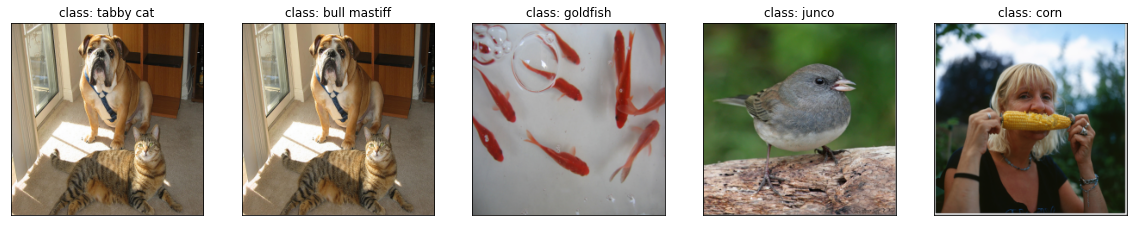

In [3]:
BATCH_SIZE = 200
DEVICE = torch.device('cuda:1')

fig, ax = subplots((1, len(examples)))
for cax, (example_name, example) in zip(ax, examples.items()):
    imshow(cax, make_displayable(example["img"]))
    cax.set_title(f"class: {example_name}")

model, input_size = load_model_by_name('resnet50', DEVICE)

# define helper functions

In [4]:
def generate_map(img, evaluator, observed_classes, maskgen, params_for_generate_masks: dict):
    """
    Makeshift mapgen for demonstrations because I never implemented one in the `convenience` module. 
    """
    masks = maskgen.generate_masks(**params_for_generate_masks).unsqueeze(1)
    
    scores = evaluator.evaluate(
        img=img, 
        masks=masks,
        observed_classes=observed_classes
    )

    retainer = create_retainer(
        shape=params_for_generate_masks['target_shape'],
        expected_p1=params_for_generate_masks['p1'],
        chk_indices=[params_for_generate_masks['N'] - 1],
    )
    retainer.add_many(masks.cpu().squeeze(), scores.cpu().squeeze())
    return mit.only(retainer.get_checkpoints())[-1]

---
---
### prepare components

In [5]:
rise_meshgen = create_meshgen(CheckerboardPatternSeeds(2))
vrise_meshgen = create_meshgen(UniformRandomSeeds(2))

raw_renderer = PillowOcclusionRenderer(
    DEVICE,
    fill_polygon=True,
    outline_type='halftone',
)

try:
    evaluator = create_evaluator(
        device=DEVICE,
        model=model,
        batch_size=BATCH_SIZE,
        use_tqdm=True,
        fp16_mode=True,
    )
except RuntimeError:
    raise RuntimeError(f"CUDA Toolkit version is too low for selected CUDA device ({DEVICE}). Select another device or install PyTorch built with a higher version of CUDA toolkit")

### prepare algorithm configurations

In [6]:
methods = {
    "RISE": {
        "maskgen": create_voronoi_maskgen(
            meshgen=rise_meshgen,
            renderer=FixedGaussianBlur(FixedRandomRenderShift(raw_renderer, shift_radius=28), sigma=7.0),
        ),
        "num_meshes": 1
    },
    "VRISE": {
        "maskgen": create_voronoi_maskgen(
            meshgen=vrise_meshgen,
            renderer=FixedGaussianBlur(raw_renderer, sigma=7.0),
        ),
        "num_meshes": 20
    },
    "VRISE (no blur, few meshes)": {
        "maskgen": create_voronoi_maskgen(
            meshgen=vrise_meshgen,
            renderer=raw_renderer,
        ),
        "num_meshes": 2,
    },
    "VRISE (no blur, many meshes)": {
        "maskgen": create_voronoi_maskgen(
            meshgen=vrise_meshgen,
            renderer=raw_renderer,
        ),
        "num_meshes": 200,
    },
    "RISE (no blur)": {
        "maskgen": create_voronoi_maskgen(
            meshgen=rise_meshgen,
            renderer=FixedRandomRenderShift(raw_renderer, shift_radius=28),
        ),
        "num_meshes": 1
    },
}

## generate a saliency map using each of defined methods

In [7]:
try:
    for example_name, example in tqdm(examples.items(), desc="examples", leave=False):
        example["saliency_maps"] = {
            method_name: generate_map(
                evaluator=evaluator,
                maskgen=method_details['maskgen'],
                img=example['img'], 
                observed_classes=example['class'],
                params_for_generate_masks=dict(N=2000, M=method_details['num_meshes'], s=7**2, p1=0.5, target_shape=input_size),
            )
            for method_name, method_details
            in tqdm(methods.items(), desc="methods", leave=False)
        }
except RuntimeError as e:
    raise RuntimeError("VRAM capacity exceeded. Reduce BATCH_SIZE, restart the kernel and re-run the notebook.")

## evaluate saliency map quality using Alteration Game metric (aka Causal Metric)

In [11]:
GAME_TYPES = {
    "insertion": functools.partial(BatchedInsertionGame, reverse=False, substrate_fn=BatchedInsertionGame.default_substrate()),
    "deletion": functools.partial(BatchedDeletionGame, reverse=False, substrate_fn=BatchedDeletionGame.default_substrate()),
}

game_runner = BatchedGameRunner()

_game_states = {}
for example_name, example in tqdm(examples.items(), desc="examples", leave=False):
    example["scores"] = dict.fromkeys(example['saliency_maps'], None)
    for method_name in example['saliency_maps']:
        example["scores"][method_name] = dict.fromkeys(GAME_TYPES.keys(), None)
        for game_type, GameClass in GAME_TYPES.items():
            game = GameClass(
                model=model,
                image=example['img'].to(DEVICE),
                explanation=example['saliency_maps'][method_name].to(DEVICE),
                batch_size=BATCH_SIZE,
                step_size=224,
                observed_classes=example['class'],
            )
            
            game_runner.run(game)
            example["scores"][method_name][game_type] = game.scores

----
# Visualize sample saleincy maps

#### For `insertion game`, **higher** scores are better.
#### For `deletion game`, **lower** scores are better.

### Brightest regions of the map are the most salient

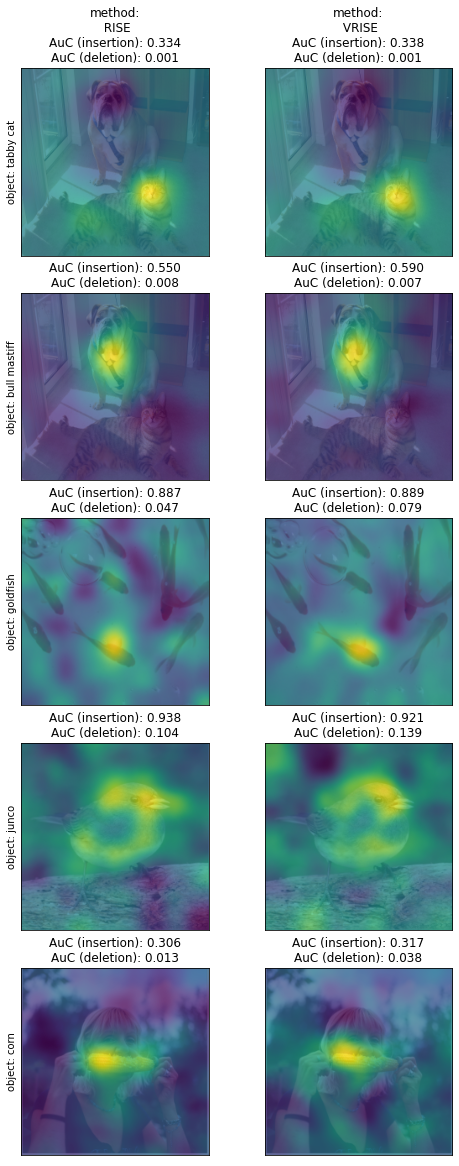

In [12]:
fig, ax = subplots((len(examples), 2))
for y, (example_name, example) in enumerate(examples.items()):
    for x, (method_name, saliency_map) in enumerate({k: v for k, v in example['saliency_maps'].items() if ' ' not in k}.items()):
        cax = ax[y,x]
        imshow(cax, saliency_map)
        imshow(cax, make_displayable(example['img']), alpha=.25)
        
        title_base = f"method:\n {method_name}"
        scores = '\n'.join([
            f"AuC ({game}): {calc_auc(game_scores)[0]:.3f}" 
            for game, game_scores 
            in example['scores'][method_name].items()
        ])
        
        if x == 0: cax.set_ylabel(f"object: {example_name}")
        if y == 0:
            cax.set_title(f"{title_base}\n{scores}")
        else:
            cax.set_title(scores)


---
## Visualize saliency maps generated by alternate configurations, which emphasize differences stemming from occlusion shapes

The first setup (no blur, few meshes) is known to yield poor results, but leaves clear footprints of Voronoi polygons.

The second and third configurations both omit occlussion blurring, emphasizing the differences in texture of saliency map stemming from occlusion shape

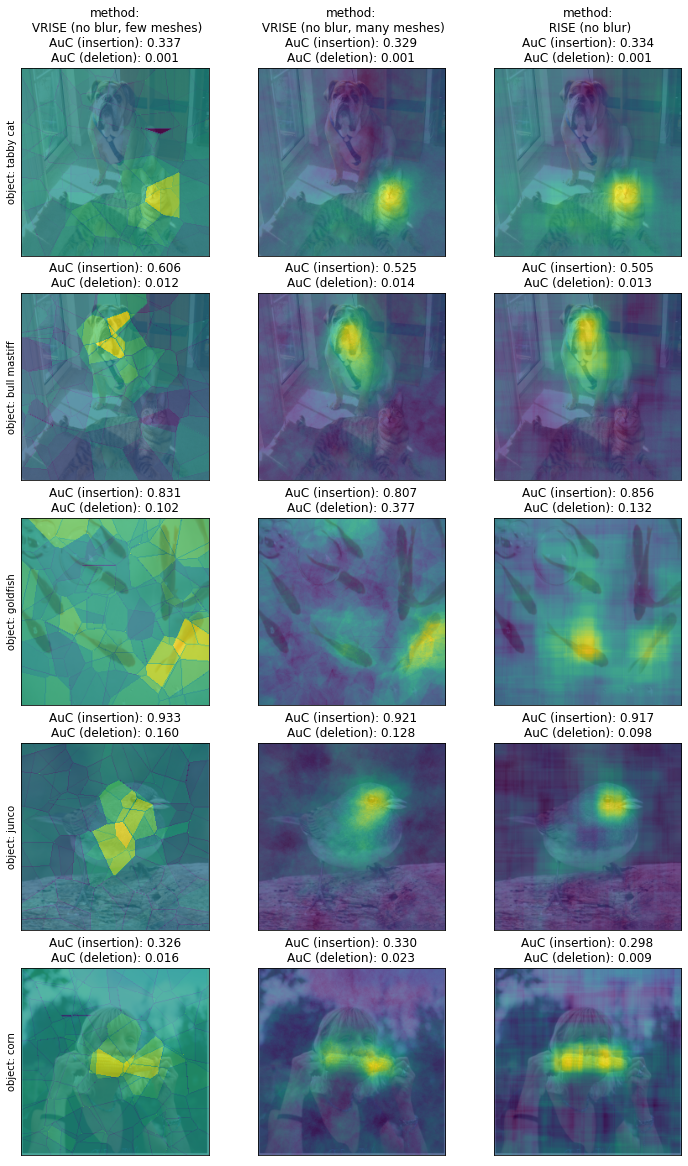

In [13]:
fig, ax = subplots((len(examples), 3))
for y, (example_name, example) in enumerate(examples.items()):
    for x, (method_name, saliency_map) in enumerate({k: v for k, v in example['saliency_maps'].items() if ' ' in k}.items()):
        cax = ax[y,x]
        imshow(cax, saliency_map)
        imshow(cax, make_displayable(example['img']), alpha=.25)
        
        title_base = f"method:\n {method_name}"
        scores = '\n'.join([
            f"AuC ({game}): {calc_auc(game_scores)[0]:.3f}" 
            for game, game_scores 
            in example['scores'][method_name].items()
        ])
        
        if x == 0: cax.set_ylabel(f"object: {example_name}")
        if y == 0:
            cax.set_title(f"{title_base}\n{scores}")
        else:
            cax.set_title(scores)